## focus on soc measurements

In [1]:
import pandas as pd
import numpy as np
df = pd.read_parquet('./material/soil_organized.pq')
print('original', df.shape)

df = df.loc[df['soc_qa']>2]
print('filter by qa', df.shape)

df = df.dropna(subset=['soc'],how='any')
df['soc_log1p'] = np.log1p(df['soc'])
print('filter by nan', df.shape)

drop_col = ['bulk.density.tot_qa', 'bulk.density.tot',
'bulk.density.fe_qa', 'bulk.density.fe', 'coarse.mass_qa',
'coarse.mass', 'coarse.vol_qa', 'coarse.vol', 'ph.h2o_qa',
'sand_qa', 'silt_qa', 'clay_qa', 'total.n_qa', 'carbonates_qa','ph.cacl2_qa',
'extractable.p_qa', 'extractable.p', 'extractable.k_qa',
'extractable.k', 'ec_qa', 'ec', 'cec_qa', 'cec','texture1', 
'texture2', 'texture1_qa', 'texture2_qa']
df = df.drop(columns=drop_col)
print('drop other properties', df.shape)

original (409369, 644)
filter by qa (124625, 644)
filter by nan (121394, 645)
drop other properties (121394, 618)


## deal with incomplete data

In [2]:
drop_col = []
covs = df.columns[18:-1].tolist()
for ii in covs:
    inum = df[ii].isna().sum()
    irto = round(inum/len(df),2)
    if 'accum.nd' in ii:
        drop_col.append(ii)
    if irto>0.0005:
        print(ii, irto)
        
drop_col.append('CHELSA_swe_1981-2010_V.2.1')
df = df.drop(columns=drop_col)   
print('drop nan col', df.shape)

accum.ndwi_glad.landsat.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240513 0.02
accum.ndvi_glad.landsat.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20240513 0.26
CHELSA_swe_1981-2010_V.2.1 0.69
drop nan col (121394, 613)


In [12]:
print(len(covs))
covs = [ii for ii in covs if ii not in drop_col]
print(len(covs))

599
594


In [13]:
import json
with open("./material/cov_all.json", "w") as fp:
    json.dump(covs, fp)

## select test dataset

In [3]:
# select time series of soc from LUCAS as test dataset
ds = df.loc[df['ref']=='LUCAS']
print('only lucas', ds.shape)

ds = ds.loc[ds['hzn_dep']==10]
print('only depth 0-20', ds.shape)

ds = ds.dropna(subset=['tile_id'])
print('only valid tile id', ds.shape)

lid = ds.groupby('id').filter(lambda x: len(x) == 3)['id'].unique().tolist() # only focus on 3-pnt series
ds = ds.loc[ds['id'].isin(lid)]
print('3-pnt series only', ds.shape)

only lucas (62578, 613)
only depth 0-20 (62200, 613)
only valid tile id (62199, 613)
3-pnt series only (39681, 613)


In [4]:
from sklearn.model_selection import train_test_split

unique_ids = ds[['id', 'tile_id']].drop_duplicates()

# merge time series from small tiles
tile_counts = unique_ids['tile_id'].value_counts()
small_groups = tile_counts[tile_counts < 3].index
unique_ids['tile_id'] = unique_ids['tile_id'].replace(small_groups, 500)

sampled_ids, _ = train_test_split(
    unique_ids, 
    train_size=3000,  
    stratify=unique_ids['tile_id'], 
    random_state=42
)

test = df[df['id'].isin(sampled_ids['id'])]
train = df[~df['id'].isin(sampled_ids['id'])]

In [5]:
test.to_parquet('./material/soc_test.pq')
print(test.shape)

(9030, 613)


In [6]:
# split train and calibration now
train.loc[train['tile_id'].isna(),'tile_id'] = 1818
tile_counts = train['tile_id'].value_counts()
small_groups = tile_counts[tile_counts < 2].index
train['tile_id'] = train['tile_id'].replace(small_groups, 1817)
trn, cal = train_test_split(
    train, 
    train_size=0.05,  
    stratify=train['tile_id'], 
    random_state=42
)
print('calibration', cal.shape)
cal.to_parquet('./material/soc_cal.pq')
print('train', trn.shape)
trn.to_parquet('./material/soc_train.pq')

/tmp/ipykernel_1768/1109542441.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tile_id'] = train['tile_id'].replace(small_groups, 1817)


calibration (106746, 613)
train (5618, 613)


## transformation check

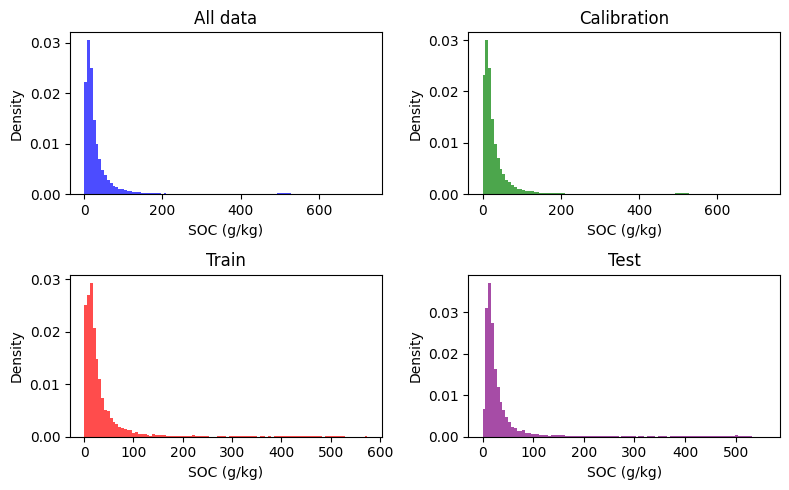

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(df["soc"], bins=100, alpha=0.7, color="blue", density=True)
axes[0, 0].set_title("All data")
axes[0, 0].set_xlabel("SOC (g/kg)")
axes[0, 0].set_ylabel("Density")

axes[0, 1].hist(cal["soc"], bins=100, alpha=0.7, color="green", density=True)
axes[0, 1].set_title("Calibration")
axes[0, 1].set_xlabel("SOC (g/kg)")
axes[0, 1].set_ylabel("Density")

axes[1, 0].hist(trn["soc"], bins=100, alpha=0.7, color="red", density=True)
axes[1, 0].set_title("Train")
axes[1, 0].set_xlabel("SOC (g/kg)")
axes[1, 0].set_ylabel("Density")

axes[1, 1].hist(test["soc"], bins=100, alpha=0.7, color="purple", density=True)
axes[1, 1].set_title("Test")
axes[1, 1].set_xlabel("SOC (g/kg)")
axes[1, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

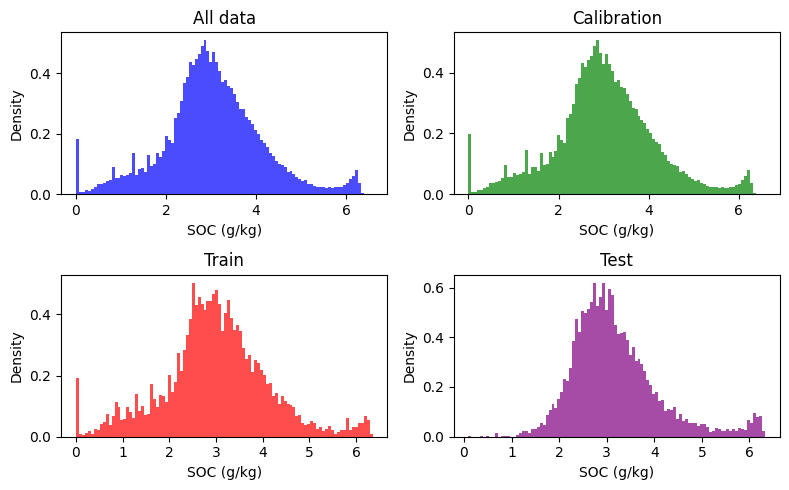

In [8]:
import numpy as np
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(df["soc_log1p"], bins=100, alpha=0.7, color="blue", density=True)
axes[0, 0].set_title("All data")
axes[0, 0].set_xlabel("SOC (g/kg)")
axes[0, 0].set_ylabel("Density")

axes[0, 1].hist(cal["soc_log1p"], bins=100, alpha=0.7, color="green", density=True)
axes[0, 1].set_title("Calibration")
axes[0, 1].set_xlabel("SOC (g/kg)")
axes[0, 1].set_ylabel("Density")

axes[1, 0].hist(trn["soc_log1p"], bins=100, alpha=0.7, color="red", density=True)
axes[1, 0].set_title("Train")
axes[1, 0].set_xlabel("SOC (g/kg)")
axes[1, 0].set_ylabel("Density")

axes[1, 1].hist(test["soc_log1p"], bins=100, alpha=0.7, color="purple", density=True)
axes[1, 1].set_title("Test")
axes[1, 1].set_xlabel("SOC (g/kg)")
axes[1, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

## feature selection

In [14]:
from model_fit import cfi_calc
prop = 'soc'
tgt = 'soc_log1p'
space = 'log1p'
output_folder = './metric/'
version = 'v20250301'
cfi = cfi_calc(cal, tgt, prop, space, output_folder, version, covar_cols=covs) # produce

ModuleNotFoundError: No module named 'model_fit'